LIBS

In [21]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'tesseract/tesseract.exe'

import numpy as np
import cv2 
import matplotlib.pyplot as plt

import re

FUNC

In [22]:
def get_placa(gray_img, kernel):
    imagens = []
    imagens.append(gray_img)
    #pegar o contorno da placa e deixar apenas ela na imagem
    bordas = cv2.Canny(gray_img, 100, 200)
    imagens.append(bordas)

    contornos, _ = cv2.findContours(bordas, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contornos = sorted(contornos, key=cv2.contourArea, reverse=True)    

    for cnt in contornos:
        epsilon = 0.02 * cv2.arcLength(cnt,True)
        aproximacao = cv2.approxPolyDP(cnt, epsilon, True)
        if cv2.isContourConvex(aproximacao) and len(aproximacao) == 4:
            localizacao = aproximacao
            break
        
    x, y, w, h = cv2.boundingRect(localizacao)
    placa_focada_img = gray_img[y:y+h, x:x+w]
    imagens.append(placa_focada_img)

    #tratamento de imagem
    valor, placa_focada_otsu_img = cv2.threshold(placa_focada_img,
                                0,
                                255,
                                cv2.THRESH_BINARY+cv2.THRESH_OTSU
                                )
    imagens.append(placa_focada_otsu_img)

    placa_focada_erosao_img = cv2.erode(placa_focada_otsu_img, kernel)
    imagens.append(placa_focada_erosao_img)

    return imagens

IMAGE

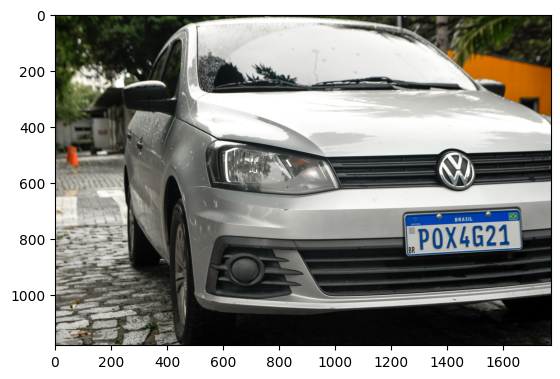

In [23]:
img = cv2.imread('placas_imagens/placa_carro2.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [24]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))    

imagens = get_placa(gray_img, kernel)

In [25]:
regex = re.compile(r'\b[a-zA-Z]{3}[a-zA-Z0-9]{4}\b')

config_tesseract = '--tessdata-dir tesseract/tessdata --psm 6'

texto = [pytesseract.image_to_string(imagem, lang='por', config=config_tesseract) for imagem in imagens]

placas = [regex.findall(t) for t in texto]

placas_flat = [placa for sublist in placas for placa in sublist]
print(placas_flat)

['POX4G21', 'POX4G24']


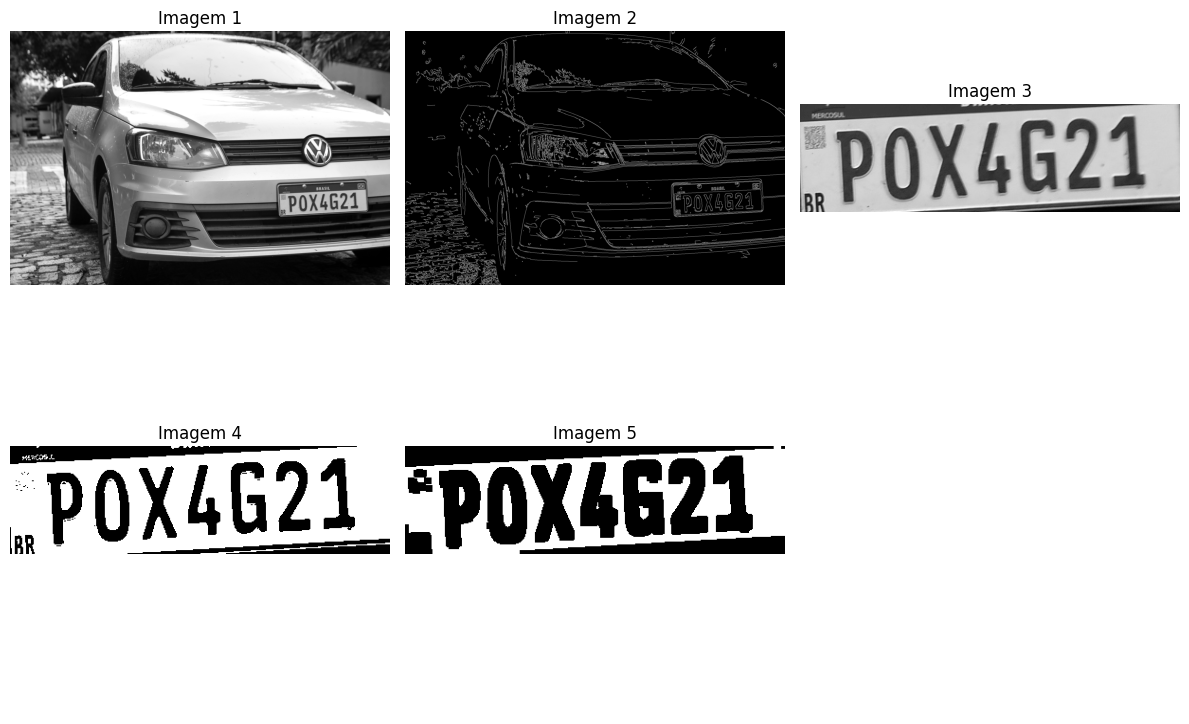

In [26]:
# Criar uma figura com subplots
num_imagens = len(imagens)
cols = 3  # Número de colunas
rows = (num_imagens + cols - 1) // cols  # Número de linhas, ajustado para caber todas as imagens

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

# Garantir que os eixos sejam tratados como uma matriz 2D
axes = axes.flatten()

# Plotar cada imagem em um subplot
for i, img in enumerate(imagens):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Imagem {i+1}")
    axes[i].axis('off')  # Esconde os eixos

# Esconder os eixos extras se houver
for ax in axes[num_imagens:]:
    ax.axis('off')

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show()

BLACKHAT

In [27]:
def get_placa_blackhat(gray_img, kernel):
    imagens = []
    imagens.append(gray_img)
    #pegar o contorno da placa e deixar apenas ela na imagem
    chapeu_preto = cv2.morphologyEx(gray_img, cv2.MORPH_BLACKHAT, kernel)    
    imagens.append(chapeu_preto)

    sobel_x = cv2.Sobel(chapeu_preto, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = 1)
    sobel_x = np.absolute(sobel_x)
    sobel_x = sobel_x.astype('uint8')

    sobel_x= cv2.GaussianBlur(sobel_x, (7,7), 0)
    sobel_x = cv2.morphologyEx(sobel_x, cv2.MORPH_CLOSE, kernel)
    imagens.append(sobel_x)

    valor, limiarizacao = cv2.threshold(sobel_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    imagens.append(limiarizacao)

    kernel_quadrado = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    limiarizacao = cv2.erode(limiarizacao, kernel_quadrado, iterations = 2)
    limiarizacao = cv2.dilate(limiarizacao, kernel_quadrado, iterations = 2)
    imagens.append(limiarizacao)

    fechamento = cv2.morphologyEx(gray_img, cv2.MORPH_CLOSE, kernel_quadrado)
    valor, mascara = cv2.threshold(fechamento, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    limiarizacao = cv2.bitwise_and(limiarizacao, limiarizacao, mask = mascara)
    limiarizacao = cv2.dilate(limiarizacao, kernel_quadrado, iterations = 2)
    limiarizacao = cv2.erode(limiarizacao, kernel_quadrado)

    contornos, hierarquia = cv2.findContours(limiarizacao, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contornos = sorted(contornos, key = cv2.contourArea, reverse = True)

    for contorno in contornos:
        x, y, w, h = cv2.boundingRect(contorno)
        proporcao = float(w)/h
        if proporcao >=3 and proporcao <= 3.5:
            placa = gray_img[y:y+h, x:x+w]
            valor, regiao_interesse = cv2.threshold(placa, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            imagens.append(regiao_interesse)


    return imagens

In [28]:
kernel_retangular = cv2.getStructuringElement(cv2.MORPH_RECT, (40,13))

imagens = get_placa_blackhat(gray_img, kernel)

In [29]:
regex = re.compile(r'\b[a-zA-Z]{3}[a-zA-Z0-9]{4}\b')

config_tesseract = '--tessdata-dir tesseract/tessdata --psm 6'

texto = [pytesseract.image_to_string(imagem, lang='por', config=config_tesseract) for imagem in imagens]

placas = [regex.findall(t) for t in texto]

placas_flat = [placa for sublist in placas for placa in sublist]
print(placas_flat)

[]


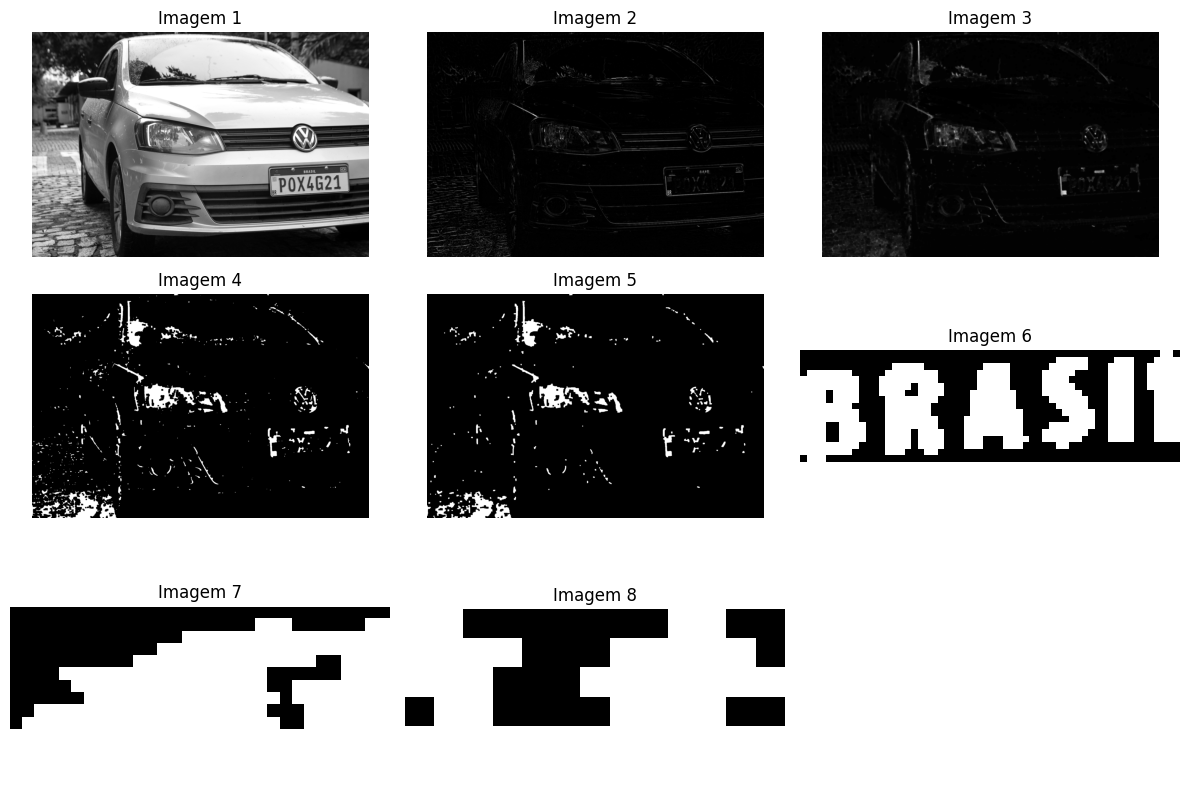

In [30]:
# Criar uma figura com subplots
num_imagens = len(imagens)
cols = 3  # Número de colunas
rows = (num_imagens + cols - 1) // cols  # Número de linhas, ajustado para caber todas as imagens

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

# Garantir que os eixos sejam tratados como uma matriz 2D
axes = axes.flatten()

# Plotar cada imagem em um subplot
for i, img in enumerate(imagens):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Imagem {i+1}")
    axes[i].axis('off')  # Esconde os eixos

# Esconder os eixos extras se houver
for ax in axes[num_imagens:]:
    ax.axis('off')

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show()